Here, we created a Time series model by using ARIMA model and forecasted next 12 days amount.

In [1]:
#Importing library
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns

In [2]:
#Reading data and viewing top 5 records
df=pd.read_excel('forecasting_data.xlsx')
df.head()

,amt,year.mon,log.amt,predicted,Lower.CI,Upper.CI
0,4899994.07,2019-05-15,15.404745,15.399578,15.168875,15.630281
1,5045282.41,2019-06-15,15.433964,15.738545,15.507842,15.969247
2,5119488.47,2019-07-15,15.448565,15.551985,15.321283,15.782688
3,7540555.87,2019-08-15,15.835806,15.557470,15.326767,15.788172
4,7131339.01,2019-09-15,15.780010,15.794670,15.563968,16.025373


In [3]:
#Formating Date Correfctly
formatted_df = df["year.mon"].dt.strftime("%y-%m-%d")
intr = pd.to_datetime(formatted_df)
df['year.mon'] = intr.dt.strftime("%b%y")
#df['year.mon']=pd.to_datetime(formatted_df.astype(str), format='%d-%m-%y')
df.index=df['year.mon']
df.drop(['year.mon'],axis=1,inplace =True)

In [4]:
df.head()

,amt,log.amt,predicted,Lower.CI,Upper.CI
year.mon,,,,,
May15,4899994.07,15.404745,15.399578,15.168875,15.630281
Jun15,5045282.41,15.433964,15.738545,15.507842,15.969247
Jul15,5119488.47,15.448565,15.551985,15.321283,15.782688
Aug15,7540555.87,15.835806,15.557470,15.326767,15.788172
Sep15,7131339.01,15.780010,15.794670,15.563968,16.025373


In [5]:
#Here. in amt and log.amt having NAN value,which needs to be deleted from the orizinal DF. Latter on we will forecast these value
df.tail()

,amt,log.amt,predicted,Lower.CI,Upper.CI
year.mon,,,,,
Nov18,NaN,NaN,15.972830,15.704486,16.241174
Dec18,NaN,NaN,16.064043,15.795699,16.332387
Jan19,NaN,NaN,16.314175,16.045830,16.582519
Feb19,NaN,NaN,15.885444,15.617100,16.153788
Mar19,NaN,NaN,15.898732,15.630388,16.167076


In [6]:
## Cleaning up the data and taking important attribute
df_new = df.iloc[:,0:2]
df_new.head()

,amt,log.amt
year.mon,,
May15,4899994.07,15.404745
Jun15,5045282.41,15.433964
Jul15,5119488.47,15.448565
Aug15,7540555.87,15.835806
Sep15,7131339.01,15.780010


In [7]:
df_new.drop(columns='amt',axis=1,inplace=True)
df_new.head()

C:\Users\ajha48\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,log.amt
year.mon,
May15,15.404745
Jun15,15.433964
Jul15,15.448565
Aug15,15.835806
Sep15,15.780010


In [8]:
df_new.tail(15)

,log.amt
year.mon,
Jan18,16.402776
Feb18,15.684375
Mar18,15.782678
Apr18,NaN
May18,NaN
Jun18,NaN
Jul18,NaN
Aug18,NaN
Sep18,NaN


In [9]:
## Drop last 12 records
df_new.drop(df_new.tail(12).index, inplace = True)
#df.replace(to_replace = np.nan, value = 0,inplace = True)
df_new.tail()

C:\Users\ajha48\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,log.amt
year.mon,
Nov17,16.045277
Dec17,16.012664
Jan18,16.402776
Feb18,15.684375
Mar18,15.782678


In [10]:
df_new.shape

(35, 1)

In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, May15 to Mar18
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   log.amt  35 non-null     float64
dtypes: float64(1)
memory usage: 560.0+ bytes


In [12]:
df_new.describe()

,log.amt
count,35.000000
mean,15.783444
std,0.250795
min,15.213426
25%,15.659774
50%,15.780104
75%,15.983524
max,16.402776


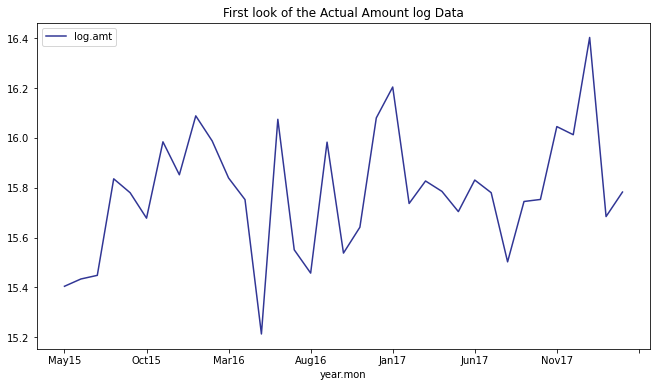

In [13]:
#df.plot(figsize=(12,8))
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
df_new.plot(figsize=(11,6), use_index=True,title='First look of the Actual Amount log Data',colormap='RdYlBu_r')
pyplot.show()

In [14]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df_new['log.amt'])
test_result

(-5.0923705920896545,
 1.4522752029677542e-05,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 6.515456736496212)

In [15]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(log_amt):
    result=adfuller(log_amt)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [16]:
adfuller_test(df_new['log.amt'])

ADF Test Statistic : -5.0923705920896545
p-value : 1.4522752029677542e-05
#Lags Used : 0
Number of Observations Used : 34
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


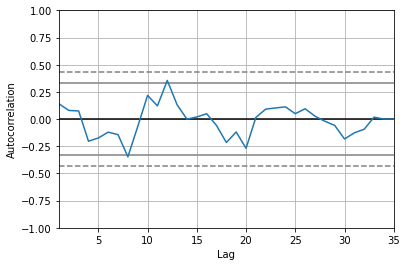

In [17]:
#AR Model
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_new['log.amt'])
plt.show()

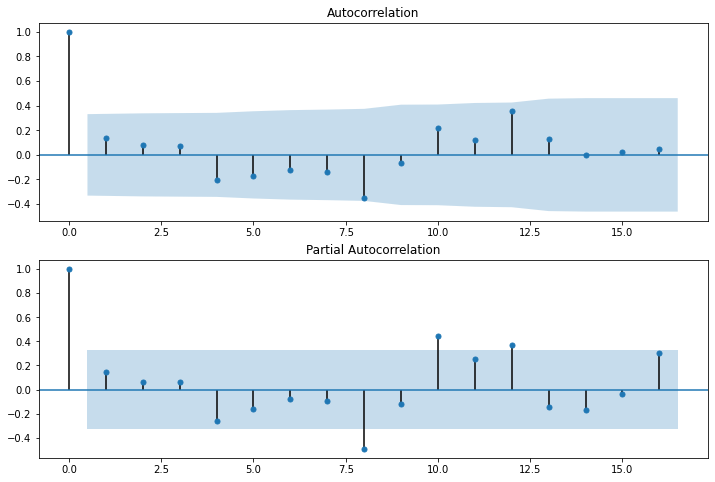

In [18]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,8))
pyplot.subplot(211)
plot_acf(df_new['log.amt'], ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(df_new['log.amt'], ax=pyplot.gca())
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017D69D2B4C0>]],
      dtype=object)

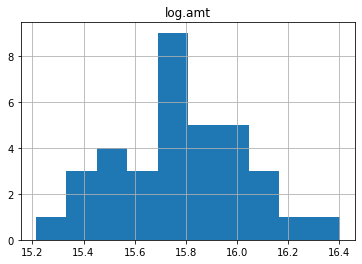

In [19]:
df_new.hist()

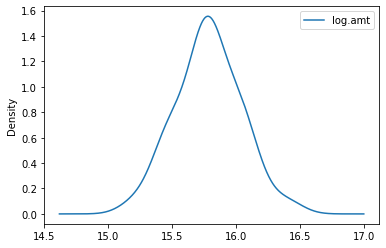

In [20]:
df_new.plot(kind='kde')

In [21]:
# separate out a validation dataset
split_point = len(df_new) - 10
dataset, validation = df_new[0:split_point], df_new[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 25, Validation 10


In [22]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [23]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=15.752, Expected=15.213
>Predicted=15.213, Expected=16.075
>Predicted=16.075, Expected=15.551
>Predicted=15.551, Expected=15.458
>Predicted=15.458, Expected=15.983
>Predicted=15.983, Expected=15.538
>Predicted=15.538, Expected=15.642
>Predicted=15.642, Expected=16.080
>Predicted=16.080, Expected=16.204
>Predicted=16.204, Expected=15.737
>Predicted=15.737, Expected=15.827
>Predicted=15.827, Expected=15.785
>Predicted=15.785, Expected=15.704
RMSE: 0.415


In [24]:
#Model Building on Train Data
from statsmodels.tsa.arima_model import ARIMA
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

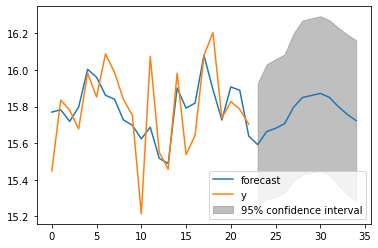

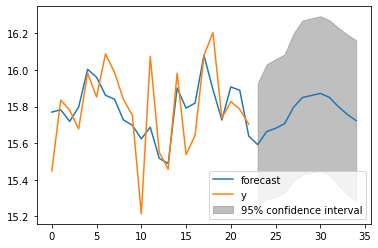

In [25]:
# fit model
model = ARIMA(X, order=(5,0,1))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,35)

In [26]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

0.2183859822728724

Buliding Final Model(Train+Test) on 'df_new' which contains 35 in sample records

In [27]:
# fit model
model=ARIMA(df_new['log.amt'],order=(9,0,1))
model_fit = model.fit()
print(model_fit.summary())
#df_new['Predicted_in']= model_fit.predict()
#df_new['Predicted']=model_fit.forecast()
#model_fit.plot_predict(1, 46)

C:\Users\ajha48\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                              ARMA Model Results                              
Dep. Variable:                log.amt   No. Observations:                   35
Model:                     ARMA(9, 1)   Log Likelihood                   8.634
Method:                       css-mle   S.D. of innovations              0.176
Date:                Mon, 17 May 2021   AIC                              6.731
Time:                        13:09:03   BIC                             25.395
Sample:                             0   HQIC                            13.174
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.7879      0.012   1371.505      0.000      15.765      15.811
ar.L1.log.amt    -0.6289      0.548     -1.148      0.251      -1.702       0.445
ar.L2.log.amt    -0.1034      0.162     

In [28]:
df_new.head()

,log.amt
year.mon,
May15,15.404745
Jun15,15.433964
Jul15,15.448565
Aug15,15.835806
Sep15,15.780010


C:\Users\ajha48\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\ajha48\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


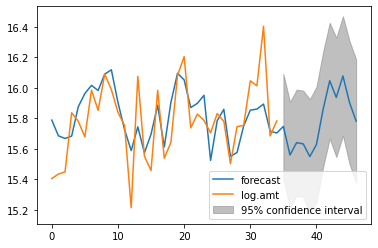

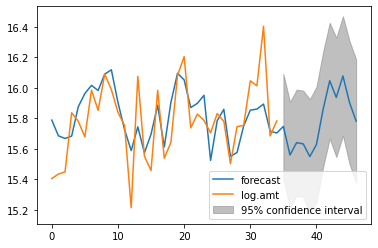

In [29]:
#Forecasting next 12 days
forecast_out=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(0,46)

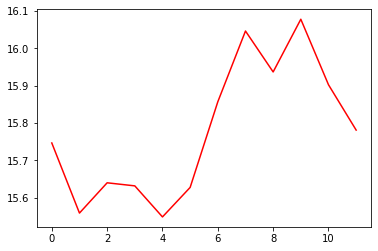

In [30]:
#Ploting only 12 Days forecasted records
plt.plot(forecast_out, color ="red") 

In [31]:
df_new['Predicted (In Sample)']=model_fit.predict()

<ipython-input-31-39bdccd8e66f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Predicted (In Sample)']=model_fit.predict()


In [32]:
index = pd.date_range(start='18-04-19',periods=12, freq='MS')+pd.DateOffset(18)
intr1 = pd.to_datetime(index)
type(intr1)

pandas.core.indexes.datetimes.DatetimeIndex

In [33]:
forecast2 = pd.DataFrame(forecast_out,columns=['Forecast(Out Sample)'],index = intr1.strftime("%b%y"))
forecast2

,Forecast(Out Sample)
May19,15.746637
Jun19,15.559201
Jul19,15.640129
Aug19,15.631928
Sep19,15.548908
Oct19,15.627774
Nov19,15.856767
Dec19,16.045985
Jan20,15.936555
Feb20,16.077477


In [34]:
data =df_new.append(forecast2)
data.head()

,log.amt,Predicted (In Sample),Forecast(Out Sample)
May15,15.404745,15.787946,NaN
Jun15,15.433964,15.684865,NaN
Jul15,15.448565,15.667283,NaN
Aug15,15.835806,15.683099,NaN
Sep15,15.780010,15.874993,NaN


Text(0, 0.5, 'Amount')

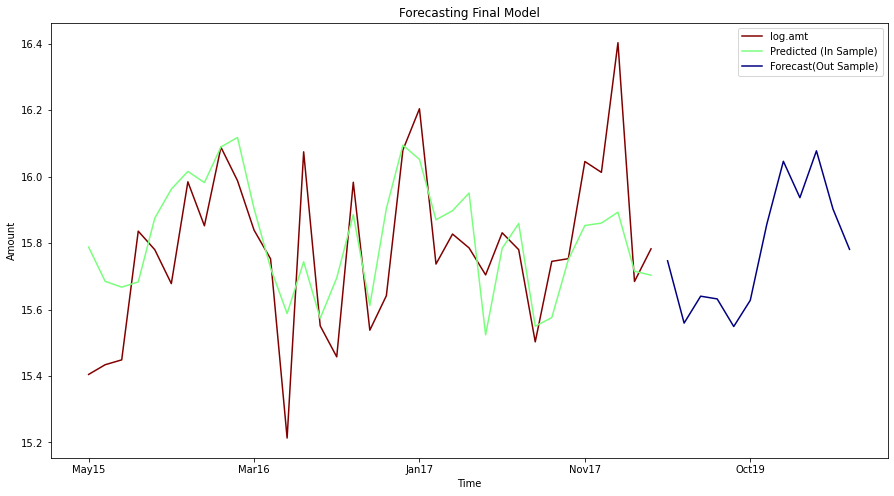

In [35]:
data[['log.amt','Predicted (In Sample)','Forecast(Out Sample)']].plot(figsize=(15,8),style ='-',use_index=True,title='Forecasting Final Model',colormap='jet_r')
plt.xlabel('Time')
plt.ylabel('Amount')


In [36]:
#12 Forecasted values
print(forecast_out)

[15.74663743 15.55920114 15.64012866 15.63192835 15.54890803 15.62777373
 15.85676683 16.04598472 15.93655515 16.07747714 15.90233596 15.78106272]


In [37]:
data.head()


,log.amt,Predicted (In Sample),Forecast(Out Sample)
May15,15.404745,15.787946,NaN
Jun15,15.433964,15.684865,NaN
Jul15,15.448565,15.667283,NaN
Aug15,15.835806,15.683099,NaN
Sep15,15.780010,15.874993,NaN


In [38]:
data.tail()

,log.amt,Predicted (In Sample),Forecast(Out Sample)
Dec19,NaN,NaN,16.045985
Jan20,NaN,NaN,15.936555
Feb20,NaN,NaN,16.077477
Mar20,NaN,NaN,15.902336
Apr20,NaN,NaN,15.781063
